In [2]:
import torch
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
from tqdm.notebook import tqdm

# Seedy dla powtarzalności wyników
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
BATCH_SIZE = 128
NUM_CLASSES = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]

train_transform = transforms.Compose([
transforms.RandomHorizontalFlip(),
transforms.RandomCrop(32, padding=4),
transforms.RandomRotation(15),
transforms.ColorJitter(brightness=0.2, saturation=0.2, contrast=0.2, hue=0.1), 
transforms.RandomErasing(p=0.1), 
transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
]),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
    ]),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.CIFAR100(
        root='./data', 
        train=True, 
        download=True, 
        transform=train_transform
    )

val_dataset = datasets.CIFAR100(
    root='./data', 
    train=True, 
    download=True, 
    transform=test_transform
)

test_dataset = datasets.CIFAR100(
    root='./data', 
    train=False, 
    download=True, 
    transform=test_transform
)

# Randomly select 50 classes (with fixed seed for reproducibility)
rng = np.random.RandomState(42)
selected_classes = rng.choice(100, NUM_CLASSES, replace=False)
selected_classes.sort()  # Sort for consistency

# Create class mapping (old index -> new index)
class_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(selected_classes)}

# Filter training dataset
train_indices = [i for i in range(len(train_dataset)) 
                if train_dataset.targets[i] in selected_classes]

val_indices = [i for i in range(len(val_dataset))
                    if val_dataset.targets[i] in selected_classes]

# Filter test dataset
test_indices = [i for i in range(len(test_dataset)) 
                if test_dataset.targets[i] in selected_classes]

# Create subsets
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(val_dataset, val_indices)
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

# Remap class indices
train_dataset.dataset.targets = [class_mapping[target] if target in class_mapping 
                                else target for target in train_dataset.dataset.targets]
val_dataset.dataset.targets = [class_mapping[target] if target in class_mapping 
                                else target for target in val_dataset.dataset.targets]
test_dataset.dataset.targets = [class_mapping[target] if target in class_mapping 
                                else target for target in test_dataset.dataset.targets]

# Save class mapping for reference
class_names = train_dataset.dataset.classes
selected_class_names = [class_names[i] for i in selected_classes]

# Split train into train and val
generator = torch.Generator().manual_seed(42)
train_split = int(0.8 * len(train_dataset))
    
indices = torch.randperm(len(train_dataset), generator=generator)
train_indices = indices[:train_split]
val_indices = indices[train_split:]
    
train_dataset = Subset(train_dataset, train_indices)
val_dataset = Subset(val_dataset, val_indices)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 

)

val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 

)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")

Number of training examples: 20000
Number of validation examples: 5000
Number of testing examples: 5000


In [6]:
print(*selected_class_names)

apple beaver bed beetle bottle bowl boy bridge bus camel can caterpillar cattle clock couch crab crocodile cup dolphin elephant forest fox girl keyboard lamp leopard lizard lobster maple_tree mountain orange otter poppy rabbit raccoon rocket rose seal shark skyscraper snail squirrel streetcar sweet_pepper tank tiger train turtle whale willow_tree


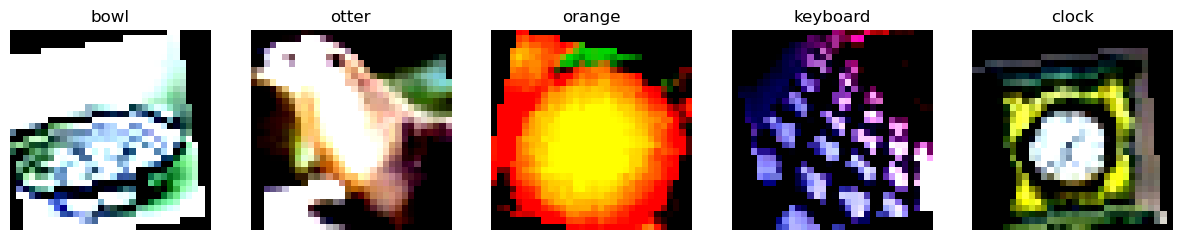

In [7]:
import matplotlib.pyplot as plt

sample = next(iter(train_loader))
images, labels = sample

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(np.clip(images[i].permute(1, 2, 0).numpy(), 0, 1))
    axes[i].set_title(selected_class_names[labels[i].item()])
    axes[i].axis('off')
plt.show()

50


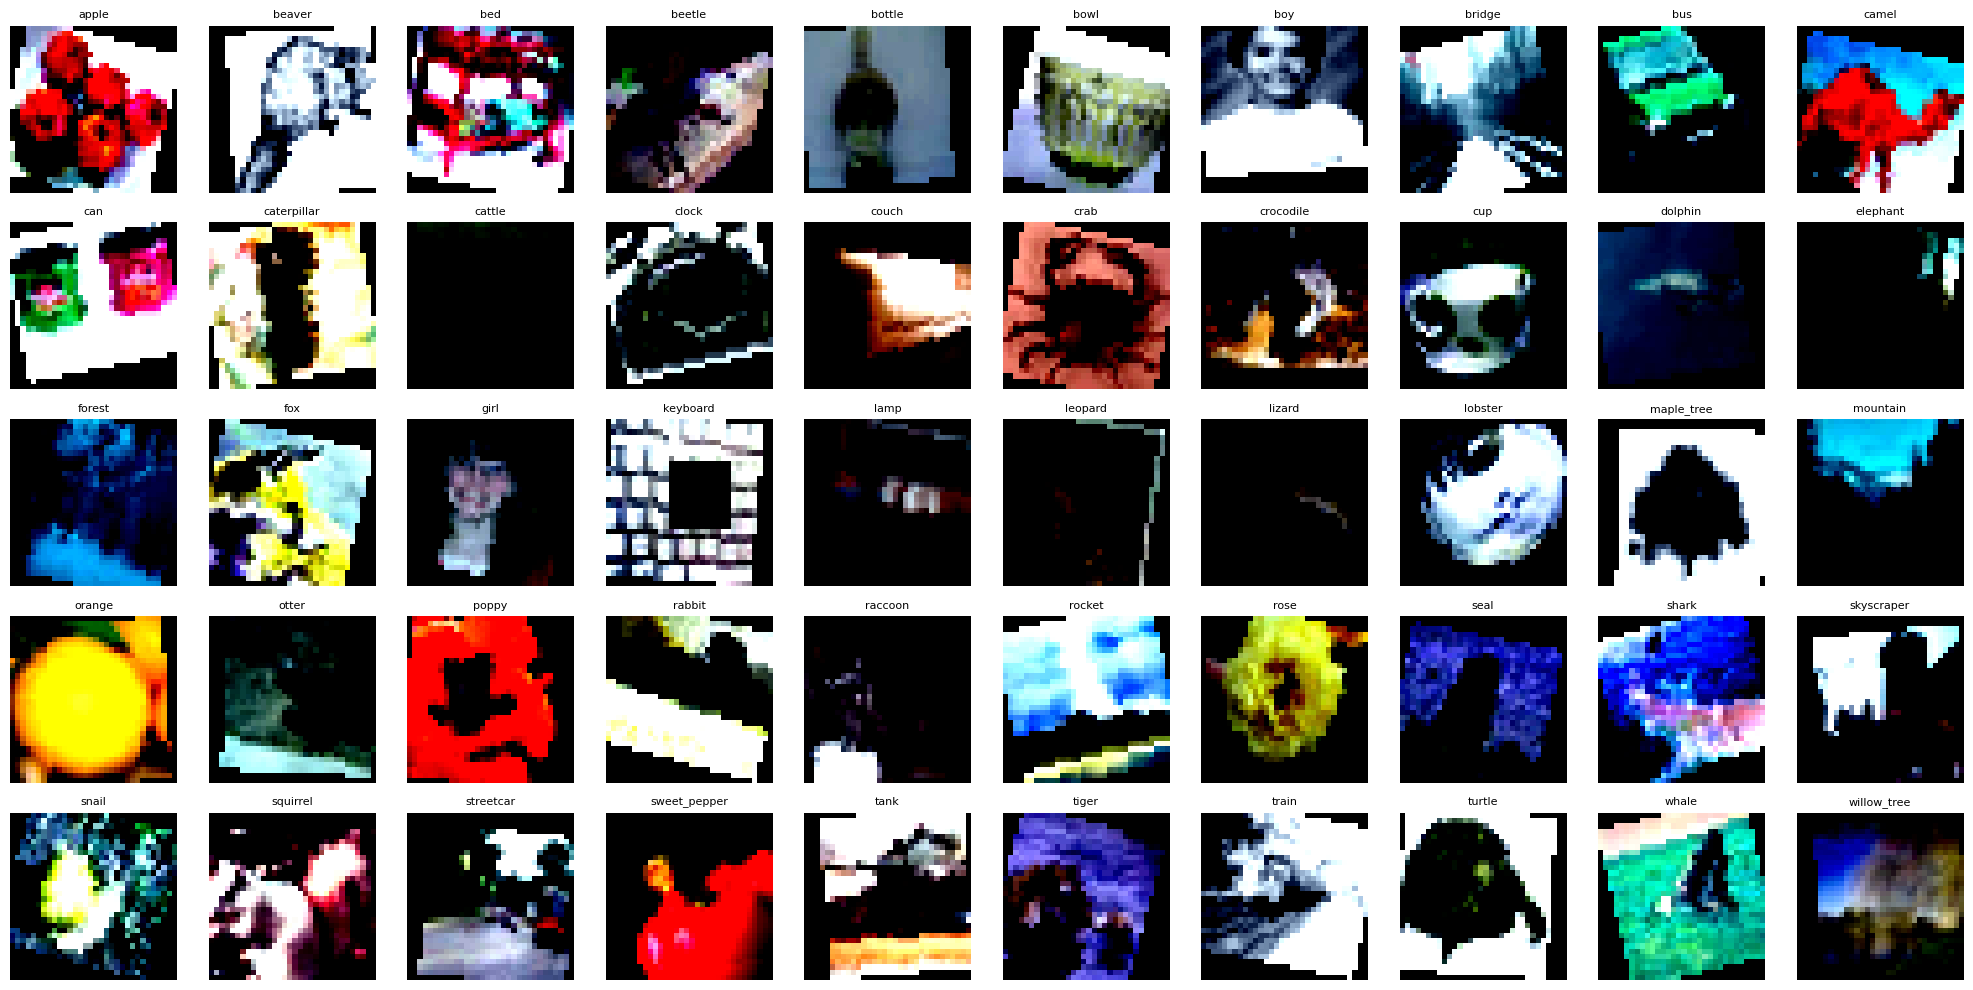

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_images = {i: None for i in range(len(selected_class_names))}

for images, labels in train_loader:
    for img, label in zip(images, labels):
        label_idx = label.item()
        if class_images[label_idx] is None:
            class_images[label_idx] = img
    if all(img is not None for img in class_images.values()):
        break

num_classes = len(selected_class_names)
print(num_classes)

num_cols = 10
num_rows = (num_classes + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 * num_rows))

for i, (class_idx, img) in enumerate(class_images.items()):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    if img is not None:
        ax.imshow(np.clip(img.permute(1, 2, 0).numpy(), 0, 1))
        ax.set_title(selected_class_names[class_idx], fontsize=8)
    ax.axis('off')

for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()
